In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax
import collections

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import xgboost as xgb

from FairReg import FairReg
from unfairness_measures import DP_unfairness, probabilistic_pred_unfairness
from plots import plot_distributions_compare, plot_predictions_compare, plot_distributions, plot_predictions

# Trivial Example (K=4)

In [2]:
def gen_X(N, n_ftr=3):
    X = np.random.normal(0, 1, (N, n_ftr))
    return X

def gen_S(X, weights=[0.16,0.34,0.34,0.16]):
    S = np.zeros(len(X))
    for i,x in enumerate(X[:,0]):
        if x <= -1:
            S[i] = 0
        elif x < 0:
            S[i] = 1
        elif x < 1:
            S[i] = 2
        else:
            S[i] = 3
    return S
    
def gen_y(X):
    N, n_ftr = X.shape
    return np.dot(X, np.ones(n_ftr) * 4) + np.random.normal(0, 1, N)  

In [3]:
#train
N_train = 1000
X_train = gen_X(N_train)
S_train = gen_S(X_train)
y_train = gen_y(X_train)
#unlab
N_unlab = 1000
X_unlab = gen_X(N_unlab)
#test
N_test = 1000
X_test = gen_X(N_test)
S_test = gen_S(X_test)
y_test = gen_y(X_test)

In [4]:
#base method
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [5]:
#classifier
clf = LogisticRegression()
clf.fit(X_train,S_train)

LogisticRegression()

In [6]:
fair_reg = FairReg(reg, clf, B=25, K=4,  p=[0.16,0.34,0.34,0.16], eps=[0.001, 0.001, 0.001, 0.001], T=10000)
fair_reg.fit(X_unlab)

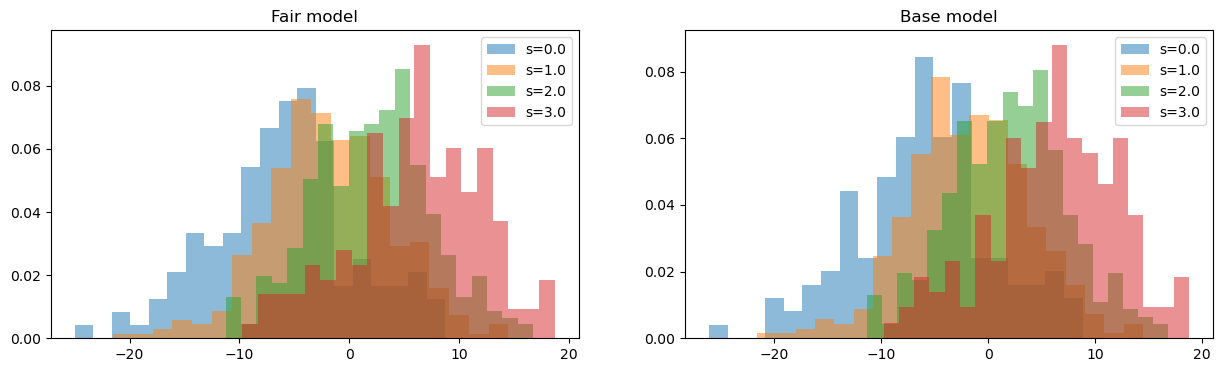

In [7]:
plot_distributions_compare(fair_reg, reg, X_test, pd.DataFrame({'S':S_test})['S'])

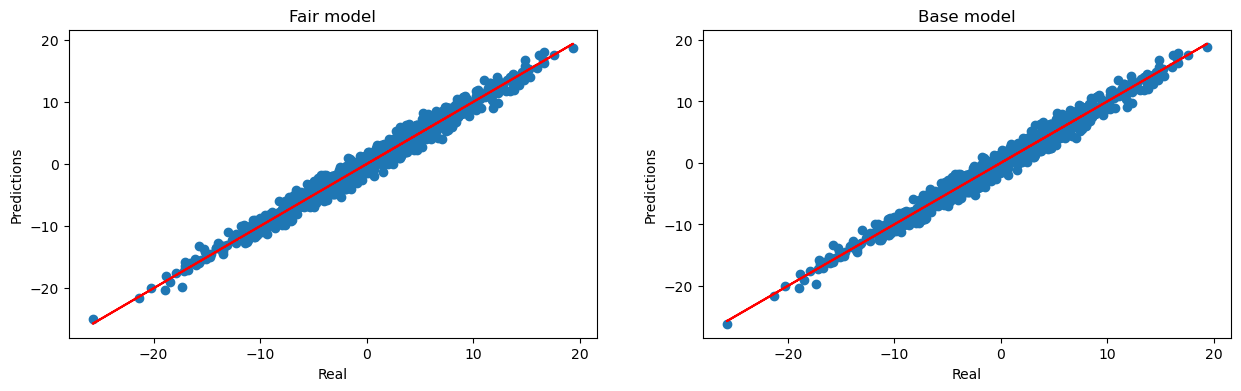

In [8]:
plot_predictions_compare(fair_reg, reg, X_test, y_test)

### Unfairness in grid

In [9]:
unf = probabilistic_pred_unfairness(fair_reg, X_test, pd.DataFrame({'S':S_test})['S'])
print("For our notion of fairness (in the grid)")
print("============================================================")
for key, value in unf.items():
    print("sum unfairness for s="+str(key)+" is "+str(sum(value)))
    print("max unfairness for s="+str(key)+" is "+str(max(value)))
    print("average unfairness for s="+str(key)+" is "+str(value.mean()))
    print("============================================================")

For our notion of fairness (in the grid)
sum unfairness for s=0.0 is 0.8161028879035745
max unfairness for s=0.0 is 0.019032667332149228
average unfairness for s=0.0 is 0.004060213372654599
sum unfairness for s=1.0 is 0.3387254292800039
max unfairness for s=1.0 is 0.013090967787145573
average unfairness for s=1.0 is 0.0016852011406965363
sum unfairness for s=2.0 is 0.36846481989042307
max unfairness for s=2.0 is 0.009619657304130173
average unfairness for s=2.0 is 0.0018331583079125536
sum unfairness for s=3.0 is 0.8049254131094893
max unfairness for s=3.0 is 0.022823522281903035
average unfairness for s=3.0 is 0.004004604045320844


### DP unfairness

In [10]:
bins = fair_reg.Q_L

For fair predictor

In [11]:
y_test_pred_fair = fair_reg.predict(X_test)
DP_unfairness(y_test_pred_fair, pd.DataFrame({'S':S_test})['S'], bins=bins)

{0.0: 0.39143661971830934,
 1.0: 0.1547742782152226,
 2.0: 0.16088343558282225,
 3.0: 0.3903642384105965}

In [12]:
print("The MSE risk of the fair predictor is "+str(mse(y_test, y_test_pred_fair)))

The MSE risk of the fair predictor is 1.0453091381857615


For base predictor

In [13]:
y_test_pred_base = reg.predict(X_test)
DP_unfairness(y_test_pred_base, pd.DataFrame({'S':S_test})['S'], bins=bins)

{0.0: 0.38932549570847474,
 1.0: 0.1508516390406155,
 2.0: 0.1604242279088904,
 3.0: 0.39091409290084783}

In [14]:
print("The MSE risk of the base predictor is "+str(mse(y_test, y_test_pred_base)))

The MSE risk of the base predictor is 1.0331087360587226


In the test data

In [15]:
DP_unfairness(y_test, pd.DataFrame({'S':S_test})['S'], bins=bins)

{0.0: 0.40719442847102466,
 1.0: 0.15692858212543248,
 2.0: 0.15354925477624853,
 3.0: 0.39961153206186295}